# Проект: Анализ бизнес-показателей


## Описание проекта

Я — маркетинговый аналитик развлекательного приложения Procrastinate Pro+. Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. 

## Цель проекта

Разобраться в возможных причинах убытков компании и помочь компании выйти в плюс. 

Для этого предстоит изучить:
* откуда приходят пользователи и какими устройствами они пользуются,
* сколько стоит привлечение пользователей из различных рекламных каналов;
* сколько денег приносит каждый клиент,
* когда расходы на привлечение клиента окупаются,
* какие факторы мешают привлечению клиентов.

## Описание данных

Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года. В нашем распоряжении три датасета: 
* Файл visits_info_short.csv - лог сервера с информацией о посещениях сайта,
* orders_info_short.csv — информация о заказах, 
* costs_info_short.csv — информация о расходах на рекламу.

Структура visits_info_short.csv:
* User Id — уникальный идентификатор пользователя,
* Region — страна пользователя,
* Device — тип устройства пользователя,
* Channel — идентификатор источника перехода,
* Session Start — дата и время начала сессии,
* Session End — дата и время окончания сессии.

Структура orders_info_short.csv:
* User Id — уникальный идентификатор пользователя,
* Event Dt — дата и время покупки,
* Revenue — сумма заказа.

Структура costs_info_short.csv:
* dt — дата проведения рекламной кампании,
* Channel — идентификатор рекламного источника,
* costs — расходы на эту кампанию.

## Загрузка библиотек и глобальных переменных
<a id='id_install'></a>

In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings

from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from ydata_profiling import ProfileReport


In [42]:
pd.options.display.float_format = '{: .2f}'.format # отображение 2 знаков после запятой в float
pd.options.display.max_rows = None
pd.options.display.max_columns = None

warnings.filterwarnings("ignore", category=RuntimeWarning) 

## Пользовательские функции

Общие ф-ции для проектов анализа данных:

In [43]:
# ф-ция приведения названий столбцов в змеиный регистр
def make_snake_columns(df):
    df.columns = df.columns.str.lower().str.replace(' ', '_')
    return df


# функция первичной проверки данных
def check_data(data_df):
    print ('\033[1m' + 'Изучим исходные данные'+ '\033[0m')
    data_df.info()
    print('\nРазмер датасета:', data_df.shape)
        
    missed_cells = data_df.isnull().sum().sum()/(data_df.shape[0]*(data_df.shape[1]-1))
    missed_rows = sum(data_df.isnull().sum(axis = 1)>0)/data_df.shape[0]
    print('\033[1m' + '\nПроверка пропусков'+ '\033[0m')
    print('Количество пропусков: {:.0f}'.format(data_df.isnull().sum().sum()))
    print('Доля пропусков: {:.1%}'.format(missed_cells)+ '\033[0m')
    print('Доля строк содержащих пропуски: {:.1%}'.format(missed_rows))

    # Проверим дубликаты
    print ('\033[1m' + '\nПроверка на дубликаты'+ '\033[0m')
    print('Количество полных дубликатов: ', data_df.duplicated().sum())
        
    # Посмотрим на сами данные
    print ('\033[1m' + '\nПервые 5 строк датасета'+ '\033[0m')
    display(data_df.head())
    
    # Списки количественных и категориальных столбцов
    numeric_columns = list(data_df.select_dtypes(include=['number']).columns)
    categorical_columns = (data_df.select_dtypes(include=['object']).columns)
    
    print('\033[1m' + '\nОписание количественных данных:'+ '\033[0m')
    display(data_df.describe().T)   
    
    if len(categorical_columns) > 0: # проверка на наличие категориальных столбцов
        print('\033[1m' + '\nОписание категориальных данных:'+ '\033[0m')
        display(data_df.describe(include='object').T)     
    
        print('\033[1m' + '\nВывод уникальных значений по каждому категориальному признаку:'+ '\033[0m')                       
        for i in categorical_columns:
            print('\033[1m' + str(i) + '\033[0m')
            display(data_df[i].value_counts())            

Зададим функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Это функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

In [44]:
# функция для создания пользовательских профилей
# def get_profiles(sessions, orders, events, ad_costs, event_names=[]):

def get_profiles(sessions, orders, ad_costs): # events не используется

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].to_numpy().astype('datetime64[M]') # ! в pandas-2.2 требуется преобразование в numpy

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles


In [45]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [46]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [47]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

In [48]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [49]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

In [50]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

In [51]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей CAC')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

## Загрузка данных

In [52]:
url = 'https://code.s3.yandex.net/datasets/'

visits, orders, costs = (
    pd.read_csv(url + 'visits_info_short.csv', parse_dates=['Session Start', 'Session End'], dayfirst=False), # визиты
    pd.read_csv(url + 'orders_info_short.csv', parse_dates=['Event Dt'], dayfirst=False), # заказы
    pd.read_csv(url + 'costs_info_short.csv', parse_dates=['dt'], dayfirst=False)   # расходы на рекламу 
)


## Первичный осмотр данных

In [53]:
ProfileReport(visits).to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [54]:
ProfileReport(orders).to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [55]:
ProfileReport(costs).to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

**Краткие итоги:**

Результаты проверок датасетов visits, orders и costs:
* Проверка пропусков - Количество пропусков: 0
* Проверка на дубликаты - Количество полных дубликатов:  0

**Вывод:**
* Во всех датасетах отсутствуют полные дубликаты и пропуски => обработка не требуется
* Во всех датасетах даты имеют тип Object => требуется приведение к типу Date и DateTime


## Предобработка данных

Приведение названий столбцов в змеиный регистр

In [56]:
# приведем названия столбцов в змеиный регистр
visits, orders, costs = (
    make_snake_columns(visits), # визиты
    make_snake_columns(orders), # заказы
    make_snake_columns(costs)   # расходы на рекламу 
)

print(list(visits.columns))
print(list(orders.columns))
print(list(costs.columns))

['user_id', 'region', 'device', 'channel', 'session_start', 'session_end']
['user_id', 'event_dt', 'revenue']
['dt', 'channel', 'costs']


Обработка полей типа дата

In [57]:
# преобразование данных о времени

costs['dt'] = pd.to_datetime(costs['dt']).dt.date 

## Исследовательский анализ данных

- Составим профили пользователей. Определим минимальную и максимальную даты привлечения пользователей.
- Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.
- Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства.
- Изучим рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

После каждого пункта сформулируем выводы.

### Составление профилей пользователей. Определение минимальной и максимальной даты привлечения пользователей.

In [58]:
# получаем профили пользователей
profiles = get_profiles(visits, orders, costs)
display(profiles.head(5)) 

# мин и макс даты привлечения пользователей
print('Минимальная дата привлечения пользователей:', profiles['dt'].min()) 
print('Максимальная дата привлечения пользователей:', profiles['dt'].max()) 

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.09
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.11
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.00
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.99
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.23


Минимальная дата привлечения пользователей: 2019-05-01
Максимальная дата привлечения пользователей: 2019-10-27


**Вывод:**
* Минимальная дата привлечения пользователей 2019-05-01, максимальная дата привлечения пользователей 2019-10-27
* Полученные значения минимальной и максимальной даты привлечения пользователей совпадают с описанием данных в проекте

### Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.

In [59]:
profiles.groupby("region").agg(count=("user_id", "nunique"), payer=("payer", "sum"), payer_share=("payer", "mean")
).assign(share_whole=lambda x: x['payer'] / x['count'].sum()).set_axis(["кол_польз","кол_плат", "доля_плат_рег", 'доля_плат_общ'], axis="columns", inplace=False,
).sort_values(by="кол_польз", ascending=False).style.format({'доля_плат_рег': '{:.2%}', 'доля_плат_общ': '{:.2%}'}) 


,кол_польз,кол_плат,доля_плат_рег,доля_плат_общ
region,,,,
United States,100002,6902,6.90%,4.60%
UK,17575,700,3.98%,0.47%
France,17450,663,3.80%,0.44%
Germany,14981,616,4.11%,0.41%


**Вывод:**
* Пользователи приходят в приложение из USA, UK, France и Germany
* Больше всего приходит пользователей из USA. Также в этой стране наибольшая доля платящих пользователей среди всех стран: 4.6% и по региону: 6.9%

### Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства.

In [60]:
profiles.groupby("device").agg(count=("user_id", "nunique"), payer=("payer", "sum"), payer_share=("payer", "mean")
).assign(share_whole=lambda x: x['payer'] / x['count'].sum()).set_axis(["кол_польз","кол_плат", "доля_плат_уст", 'доля_плат_общ'], axis="columns", inplace=False,
).sort_values(by="кол_польз", ascending=False).style.format({'доля_плат_уст': '{:.2%}', 'доля_плат_общ': '{:.2%}'}) 


,кол_польз,кол_плат,доля_плат_уст,доля_плат_общ
device,,,,
iPhone,54479,3382,6.21%,2.25%
Android,35032,2050,5.85%,1.37%
PC,30455,1537,5.05%,1.02%
Mac,30042,1912,6.36%,1.27%


**Вывод:**
* Наибольшее количество пользователей предпочитают iPhone. На втором месте находится Android
* Наибольшее количество платящих пользователей предпочитают iPhone: 2.25% и также наибольшая доля платящих для устройства принадлежит iPhone: 6.21%

### Изучим рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

In [61]:
profiles.groupby("channel").agg(count=("user_id", "nunique"), payer=("payer", "sum"), payer_share=("payer", "mean")
).assign(share_whole=lambda x: x['payer'] / x['count'].sum()).set_axis(["кол_польз","кол_плат", "доля_плат_кан", 'доля_плат_общ'], axis="columns", inplace=False,
).sort_values(by="кол_польз", ascending=False).style.format({'доля_плат_кан': '{:.2%}', 'доля_плат_общ': '{:.2%}'}) 


,кол_польз,кол_плат,доля_плат_кан,доля_плат_общ
channel,,,,
organic,56439,1160,2.06%,0.77%
FaceBoom,29144,3557,12.20%,2.37%
TipTop,19561,1878,9.60%,1.25%
OppleCreativeMedia,8605,233,2.71%,0.16%
LeapBob,8553,262,3.06%,0.17%
WahooNetBanner,8553,453,5.30%,0.30%
RocketSuperAds,4448,352,7.91%,0.23%
MediaTornado,4364,156,3.57%,0.10%
YRabbit,4312,165,3.83%,0.11%


**Вывод:**
* Больше всего платящих пришло с FaceBoom 2.37% и с TipTop 1.25% 
* Так же у пришедших с FaceBoom наибольшая доля платящих пользователей: 12.20% 

## Маркетинг

- Посчитаем общую сумму расходов на маркетинг.
- Выясним, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.
- Построим график с визуализацией динамики изменения расходов во времени по неделям по каждому источнику. Затем на другом графике визуализируем динамику изменения расходов во времени по месяцам по каждому источнику.
- Узнаем, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. Используем профили пользователей.

### Общая сумма расходов на маркетинг

In [62]:
print('Общая сумма расходов на маркетинг:', round(profiles['acquisition_cost'].sum(), 2))

Общая сумма расходов на маркетинг: 105497.3


### Распределение расходов по рекламным источникам

In [63]:
profiles.groupby("channel").agg({"acquisition_cost": "sum", }
                                    ).assign(acquisition_share=lambda x: x / x.sum()
                                            ).set_axis(["расх_рекл", "доля_расх_общ"], axis="columns", inplace=False,
                                                      ).sort_values(by="расх_рекл", ascending=False).style.format({'расх_рекл': '{:.1f}', 'доля_расх_общ': '{:.2%}'}) 


,расх_рекл,доля_расх_общ
channel,,
TipTop,54751.3,51.90%
FaceBoom,32445.6,30.75%
WahooNetBanner,5151.0,4.88%
AdNonSense,3911.3,3.71%
OppleCreativeMedia,2151.2,2.04%
RocketSuperAds,1833.0,1.74%
LeapBob,1797.6,1.70%
lambdaMediaAds,1557.6,1.48%
MediaTornado,954.5,0.90%


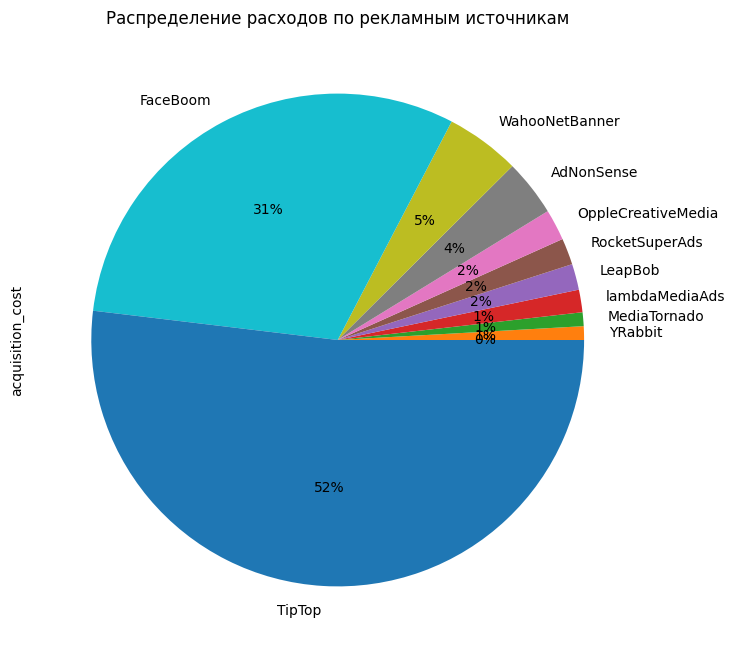

In [64]:
fig, ax = plt.subplots(figsize=(8, 8))
profiles.groupby("channel").agg({"acquisition_cost": "sum", }
                               ).sort_values(by='acquisition_cost'
                                            ).plot(kind='pie', y='acquisition_cost', autopct='%1.0f%%', ax=ax)
ax.set(title='Распределение расходов по рекламным источникам')
ax.legend().set_visible(False);


**Вывод:**
* Больше всего средств было потрачено на рекламу в TipTop: 51.90%. На втором месте по расходам на рекламу находится FaceBoom: 30.75%  

### Динамика изменения расходов на рекламу во времени по неделям и месяцам по каждому источнику

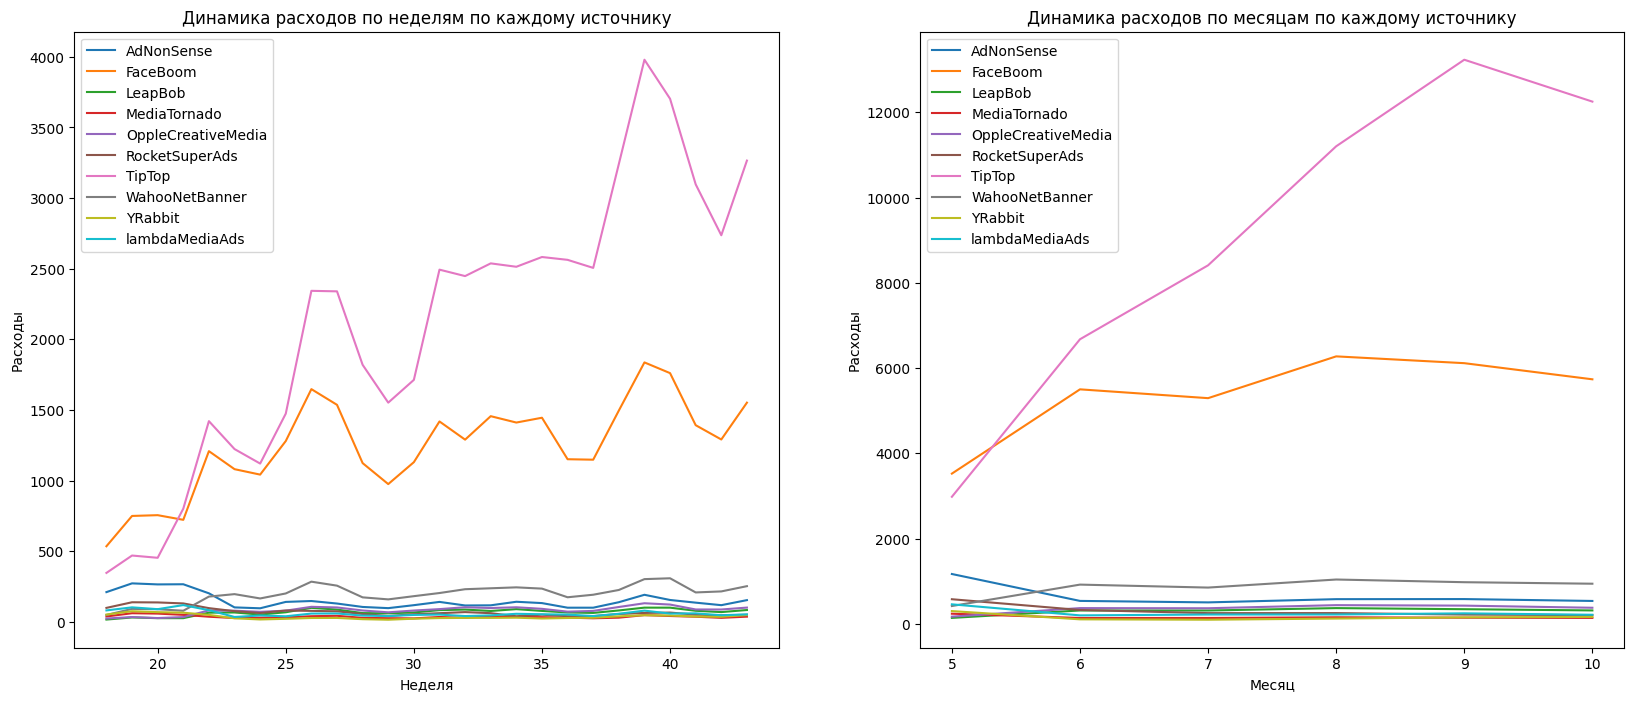

In [65]:
costs['dt'] = pd.to_datetime(costs['dt'])

# добавим столбцы с номером недели и месяца
costs['week'] = costs['dt'].dt.isocalendar().week
costs['month'] = costs['dt'].dt.month

fig, [ax0, ax1] = plt.subplots(nrows=1,ncols=2, figsize=(20, 8))

costs.pivot_table(index='week', columns='channel', values='costs', aggfunc='sum').plot(ax=ax0)
ax0.set(xlabel='Неделя', ylabel='Расходы', title='Динамика расходов по неделям по каждому источнику')
ax0.legend()

costs.pivot_table(index='month', columns='channel', values='costs', aggfunc='sum').plot(ax=ax1)
ax1.set(xlabel='Месяц', ylabel='Расходы', title='Динамика расходов по месяцам по каждому источнику')
ax1.legend();

**Вывод:**
* На графиках динамики расходов по неделям и месяцам видно, что самый сильный рост затрат на рекламу у TipTop, затем идет FaceBoom  


### Расчет средней стоимости привлечения одного пользователя (CAC) для всего проекта и для каждого источника

In [66]:
# средний CAC 
print('Средний CAC на одного пользователя для всего проекта:', round(profiles['acquisition_cost'].mean(), 2))

Средний CAC на одного пользователя для всего проекта: 0.7


In [67]:
# средний CAC по параметрам из profiles
profiles.groupby('channel').agg({'acquisition_cost': 'mean'}
                               ).rename(columns={'acquisition_cost': 'cac'}).sort_values(by='cac', ascending=False)
        

,cac
channel,
TipTop,2.80
FaceBoom,1.11
AdNonSense,1.01
lambdaMediaAds,0.72
WahooNetBanner,0.60
RocketSuperAds,0.41
OppleCreativeMedia,0.25
YRabbit,0.22
MediaTornado,0.22


**Вывод:**
* Средний CAC на одного пользователя для всего проекта: 0.7
* Дороже всего средняя стоимость привлечения одного пользователя (CAC) у TipTop: 2.80   

## Анализ окупаемости рекламы

Используя графики LTV, ROI и CAC, проанализируем окупаемость рекламы. Считаем, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. Необходимость включения в анализ органических пользователей определим самостоятельно.

In [68]:
# установим момент и горизонт анализа данных 
observation_date = datetime(2019, 10, 1).date()  # момент анализа 1 ноября 2019 года 
horizon_days = 14  # горизонт анализа 

Исключим органический трафик, тк мы не платим за этих пользователей, а доход от них может завышать довольно плачевную картину и скрыть от нас проблемы в какой-то стране или же типе устройств.

In [69]:
profiles = profiles[profiles['channel'] != 'organic']
# profiles = profiles.query('channel != "organic"')

### Анализ окупаемости рекламы c помощью графиков LTV и ROI, а также динамики LTV, CAC и ROI

#### Общая ситуация, без разбивки по категориям

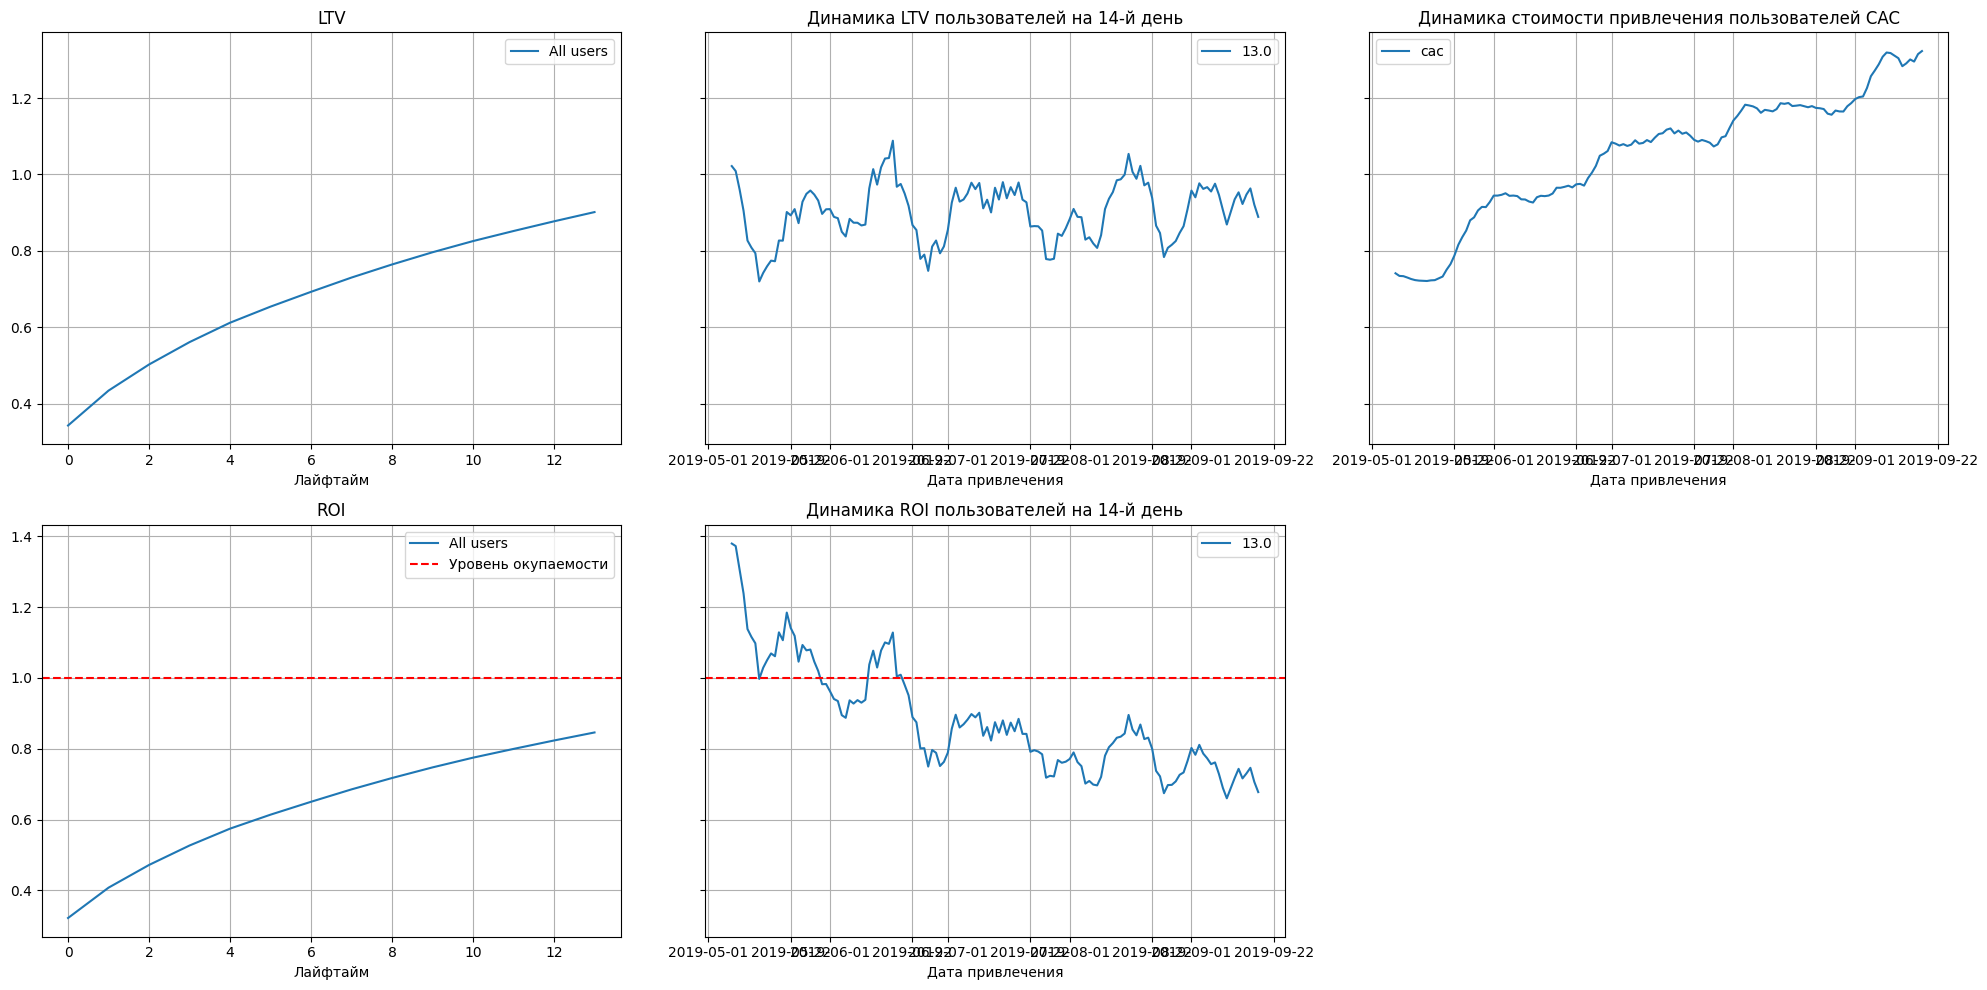

In [70]:
# считаем LTV и ROI

dimensions = []

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

**Вывод:**
* LTV постепенно растет, но в динамике на 14й день LTV скорее стоит на месте, чем растет
* Стоимость привлечения CAC растет. Это может оказывать влияние на окупаемость рекламы
* Исходя из общего ROI, реклама окупилась. Но в динамике ROI на 14й день, ситуация изменилась в худшую сторону. Реклама перестала окупаться, а тенденция пошла на постепенное снижение в сторону большего ухудшения
* Стоимость привлечения CAC растет, а окупаемость ROI снижается.

#### Разбивка по странам

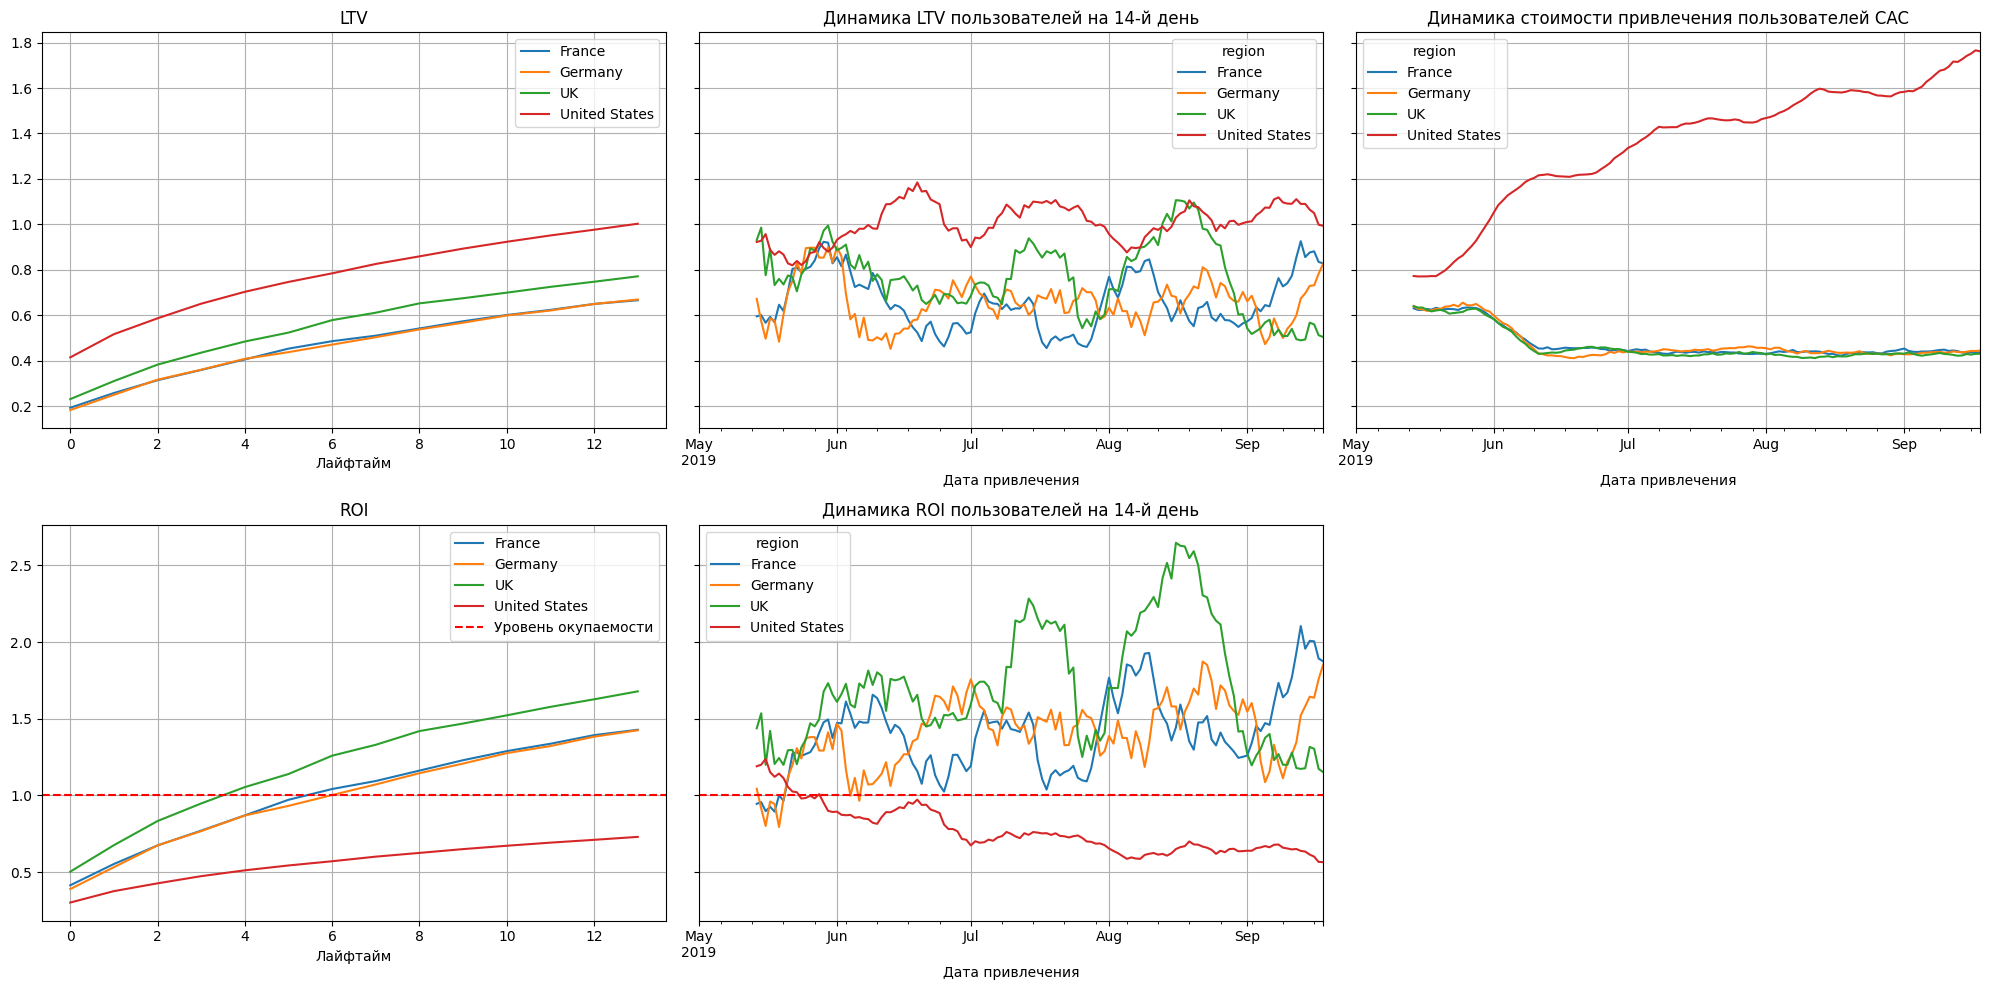

In [71]:
# смотрим окупаемость с разбивкой по странам

dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

**Вывод:**
* Стоимость привлечения CAC у всех стран стабильно на одном уровне, кроме USA. В USA резкий рост стоимости привлечения CAC. 
* Исходя из ROI, реклама окупилась и растет у всех стран, кроме USA. 
* В динамике ROI на 14й день, у всех стран ROI стабильно выше уровня окупаемости, кроме USA. Для USA реклама перестала окупаться в начале июня и тенденция идет к дальнейшему снижению в сторону ухудшения
* Найден проблемный регион. Это USA.

#### Разбивка по устройствам

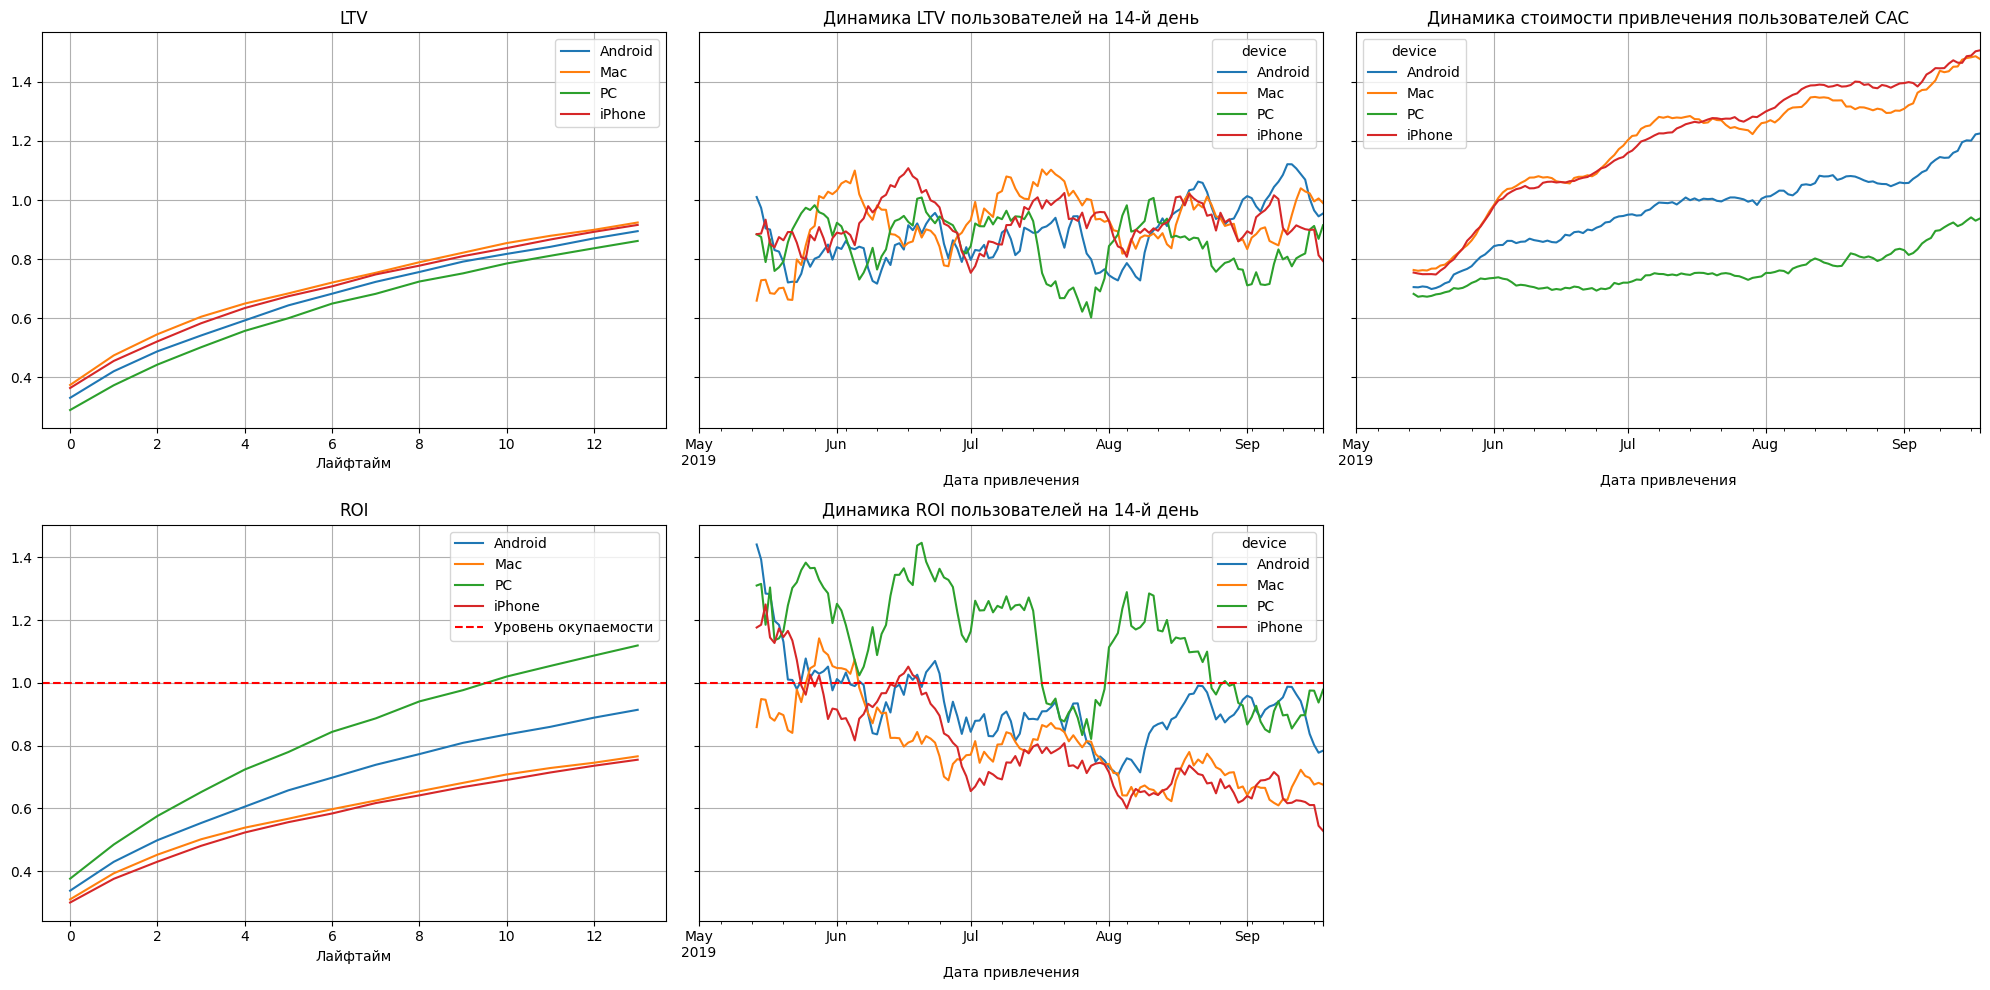

In [72]:
# смотрим окупаемость с разбивкой по устройствам

dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

**Вывод:**
* Стоимость привлечения CAC по всем устройствам растет 
* Исходя из ROI, реклама окупилась по PC и Android. По Mac и iPhone еще не перешла уровень окупаемости 
* В динамике ROI на 14й день, у всех устройств тенденция идет на постепенное снижение ниже уровня окупаемости
* Негативный фактор по всем устройствам повышение стоимости привлечения CAC. Возможно это послужило причиной ухудшения динамики окупаемости рекламы ROI

#### Разбивка по рекламным каналам

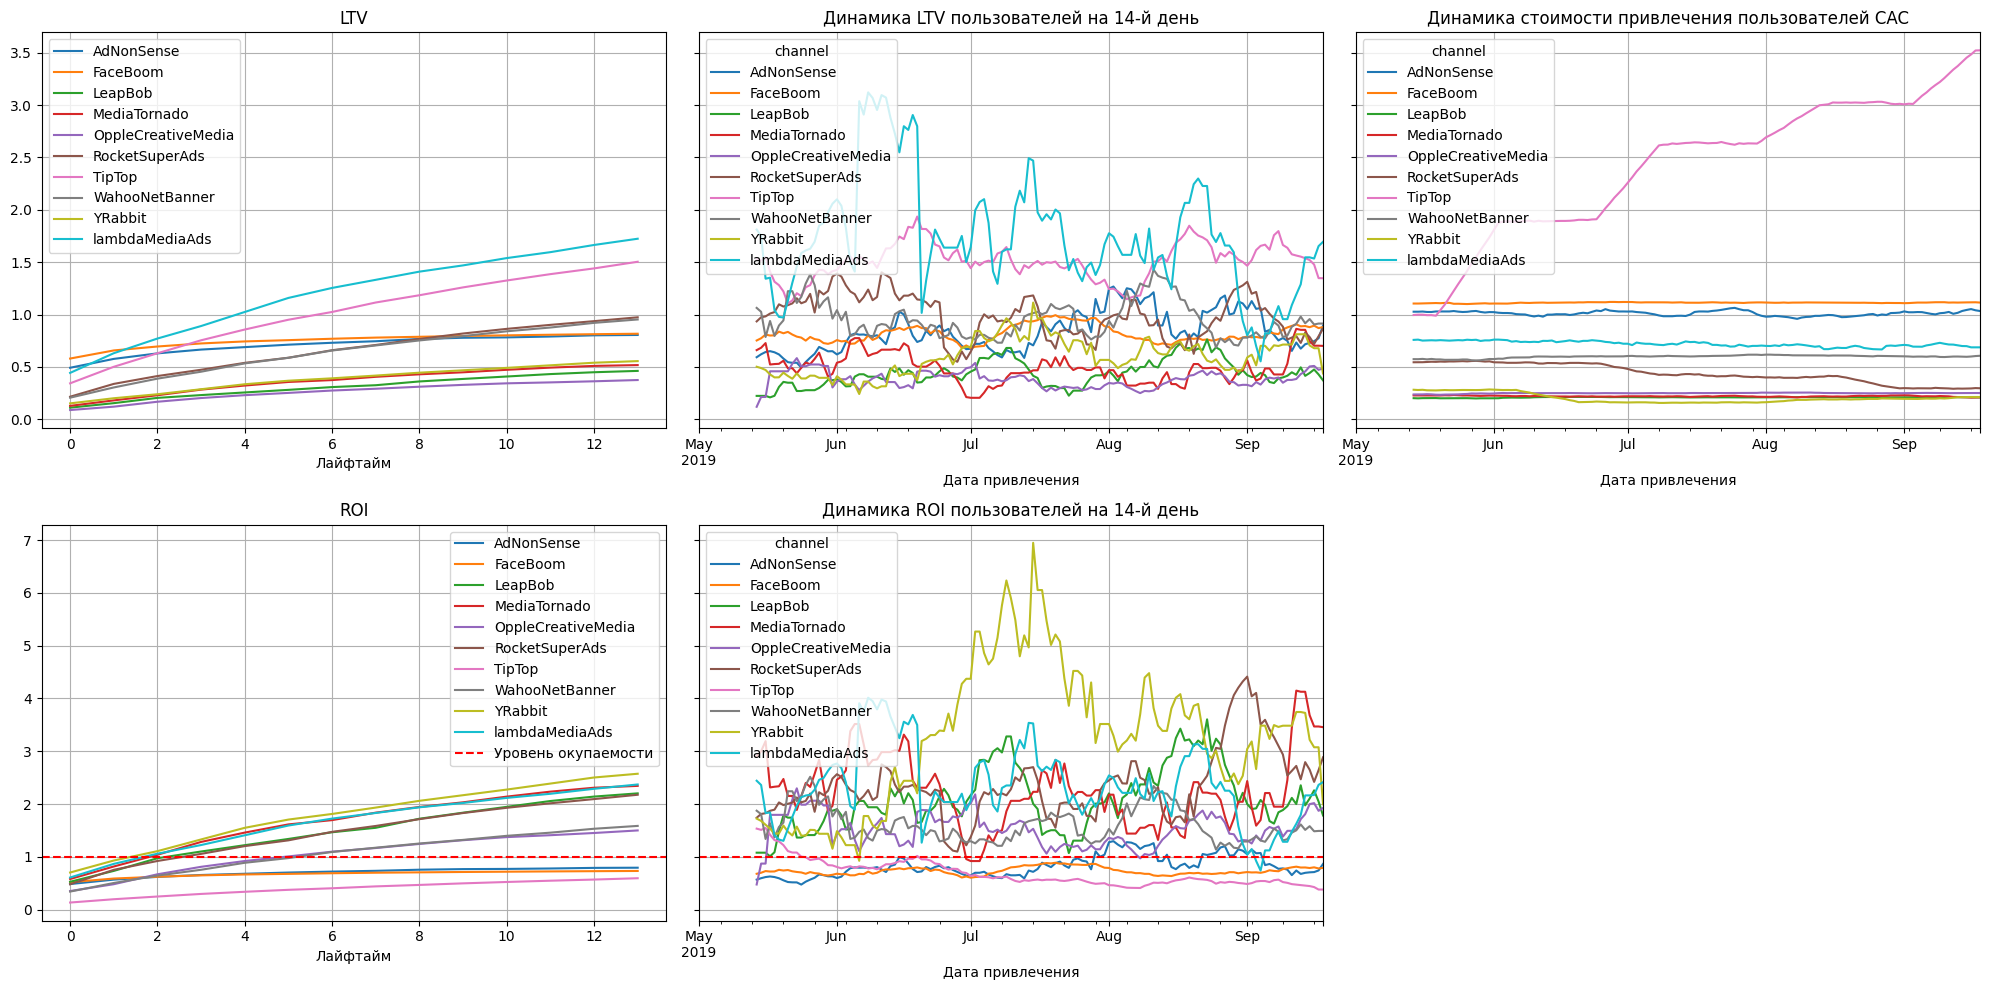

In [73]:
# смотрим окупаемость с разбивкой по рекламным каналам

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

**Вывод:**
* Стоимость привлечения CAC по всем каналам находится на одном уровне, кроме TipTop. В TipTop наблюдается резкий рост CAC
* Исходя из ROI и динамики ROI реклама окупилась по всем, кроме TipTop, FaceBoom и AdNonSense
* Найдены проблемные рекламные каналы. Это TipTop, FaceBoom и AdNonSense 

### Анализ конверсии пользователей и динамики её изменения

#### Общая ситуация, без разбивки по категориям

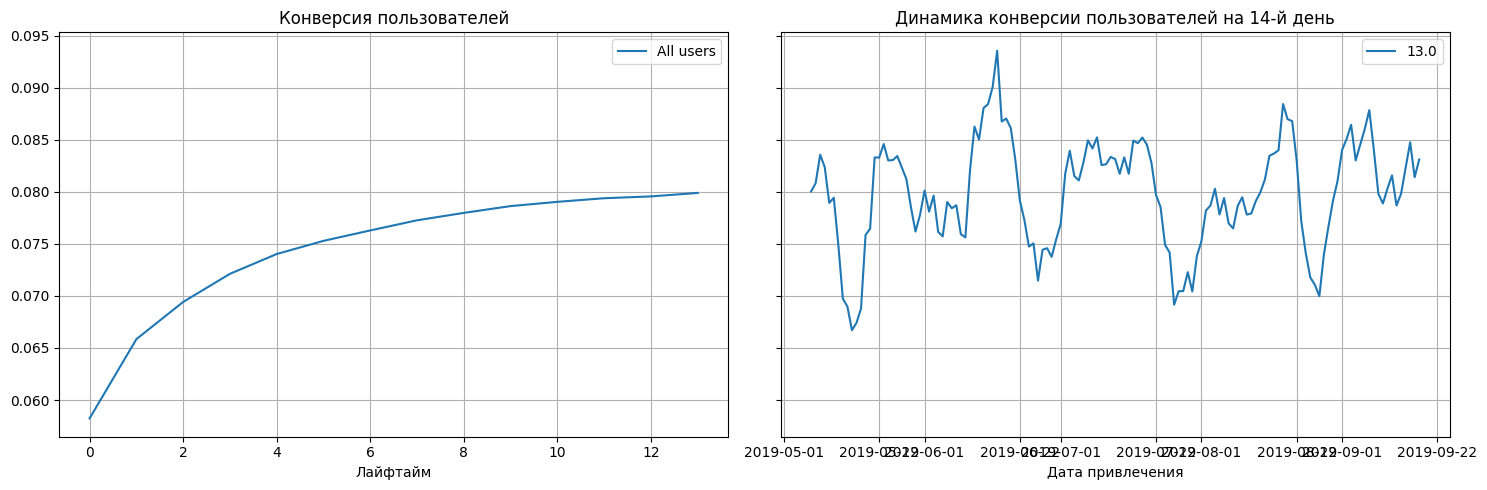

In [74]:
# смотрим конверсию 

dimensions = []

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

**Вывод:**
* Общая конверсия пользователей растет, динамика аналогичная
* Все в порядке, поэтому не делаем разбивку

### Анализ удержания пользователей

#### Общая ситуация, без разбивки по категориям

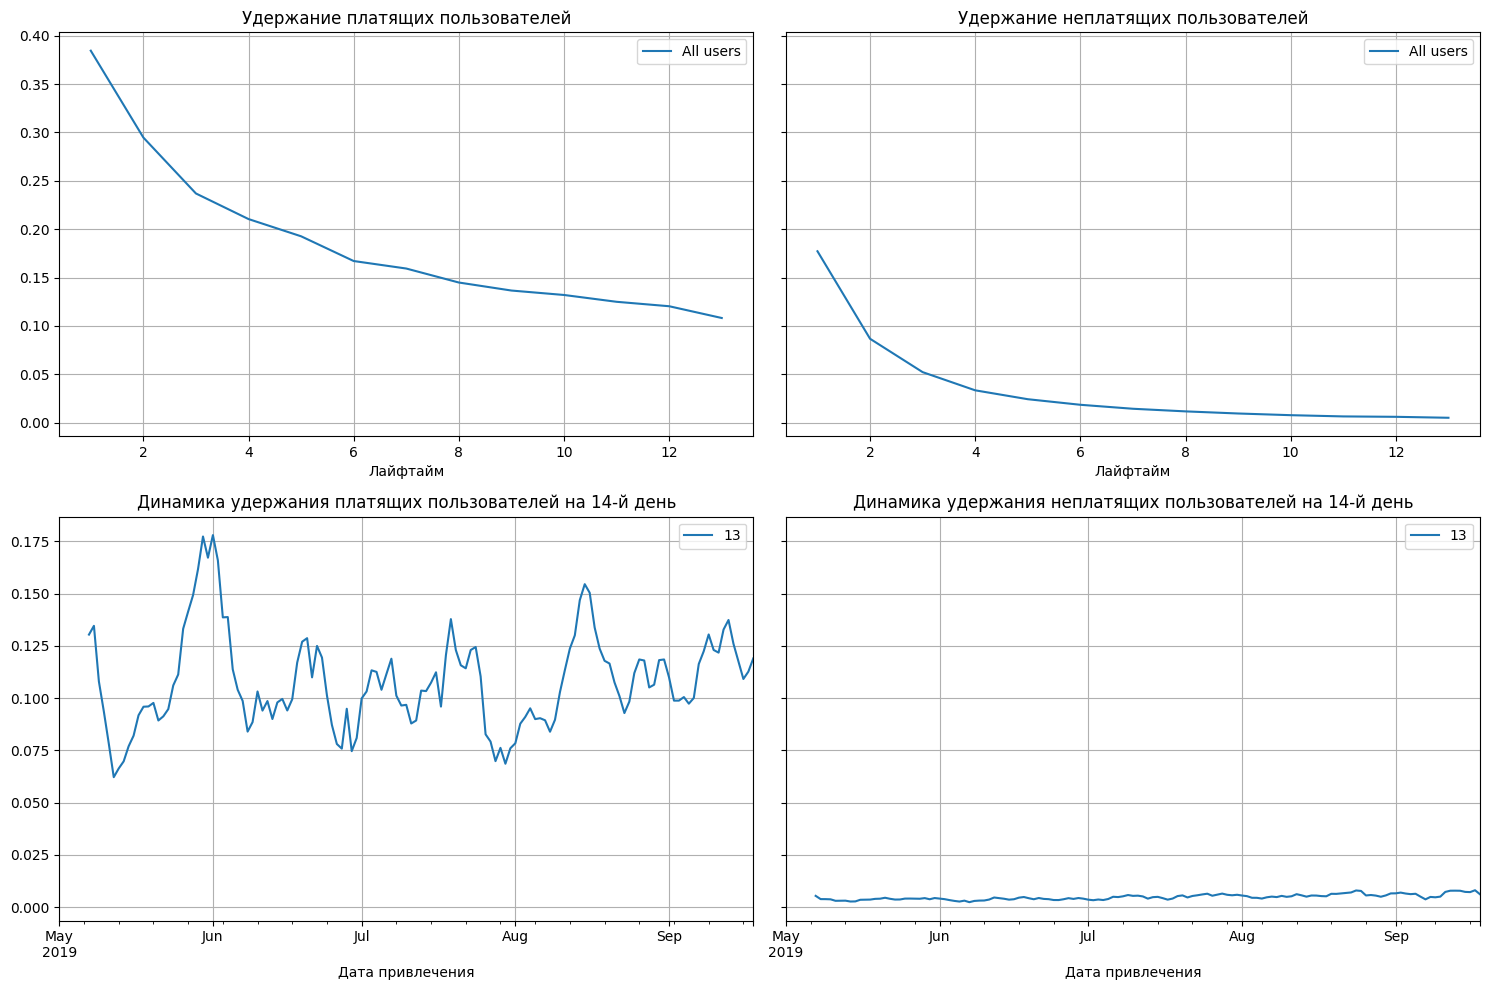

In [75]:
# смотрим удержание

dimensions = []

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

**Вывод:**
* Аномалии не найдены

#### Разбивка по странам

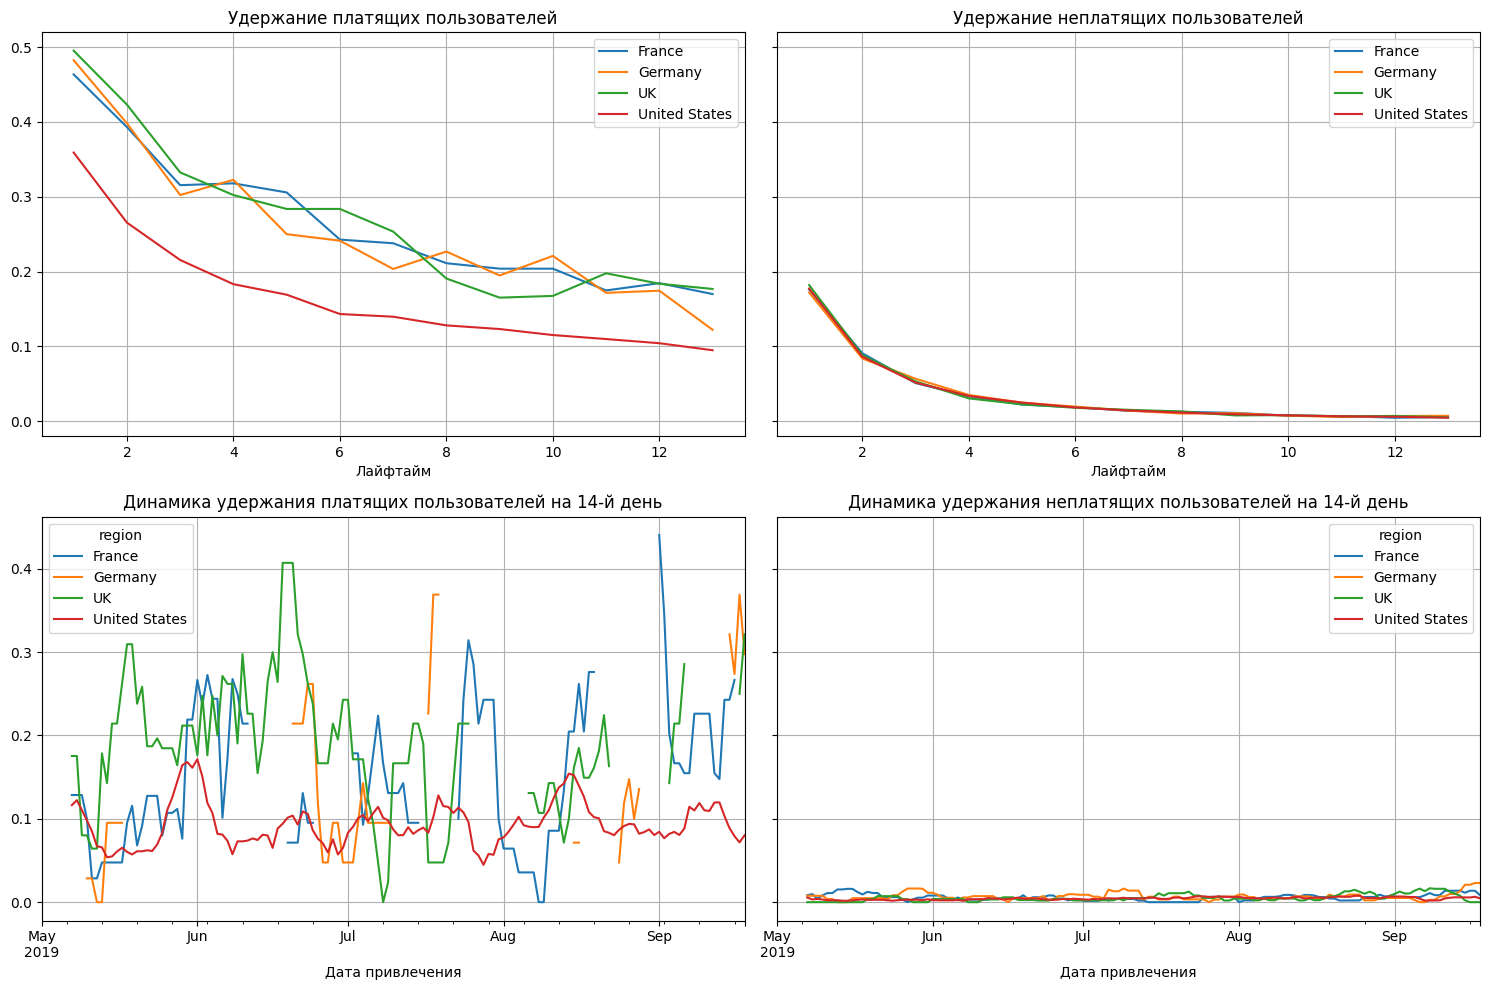

In [76]:
# смотрим удержание с разбивкой по странам

dimensions = ['region']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

**Вывод:**
* Показатель удержания платящих пользователей в USA ниже, чем у других стран

#### Разбивка по устройствам

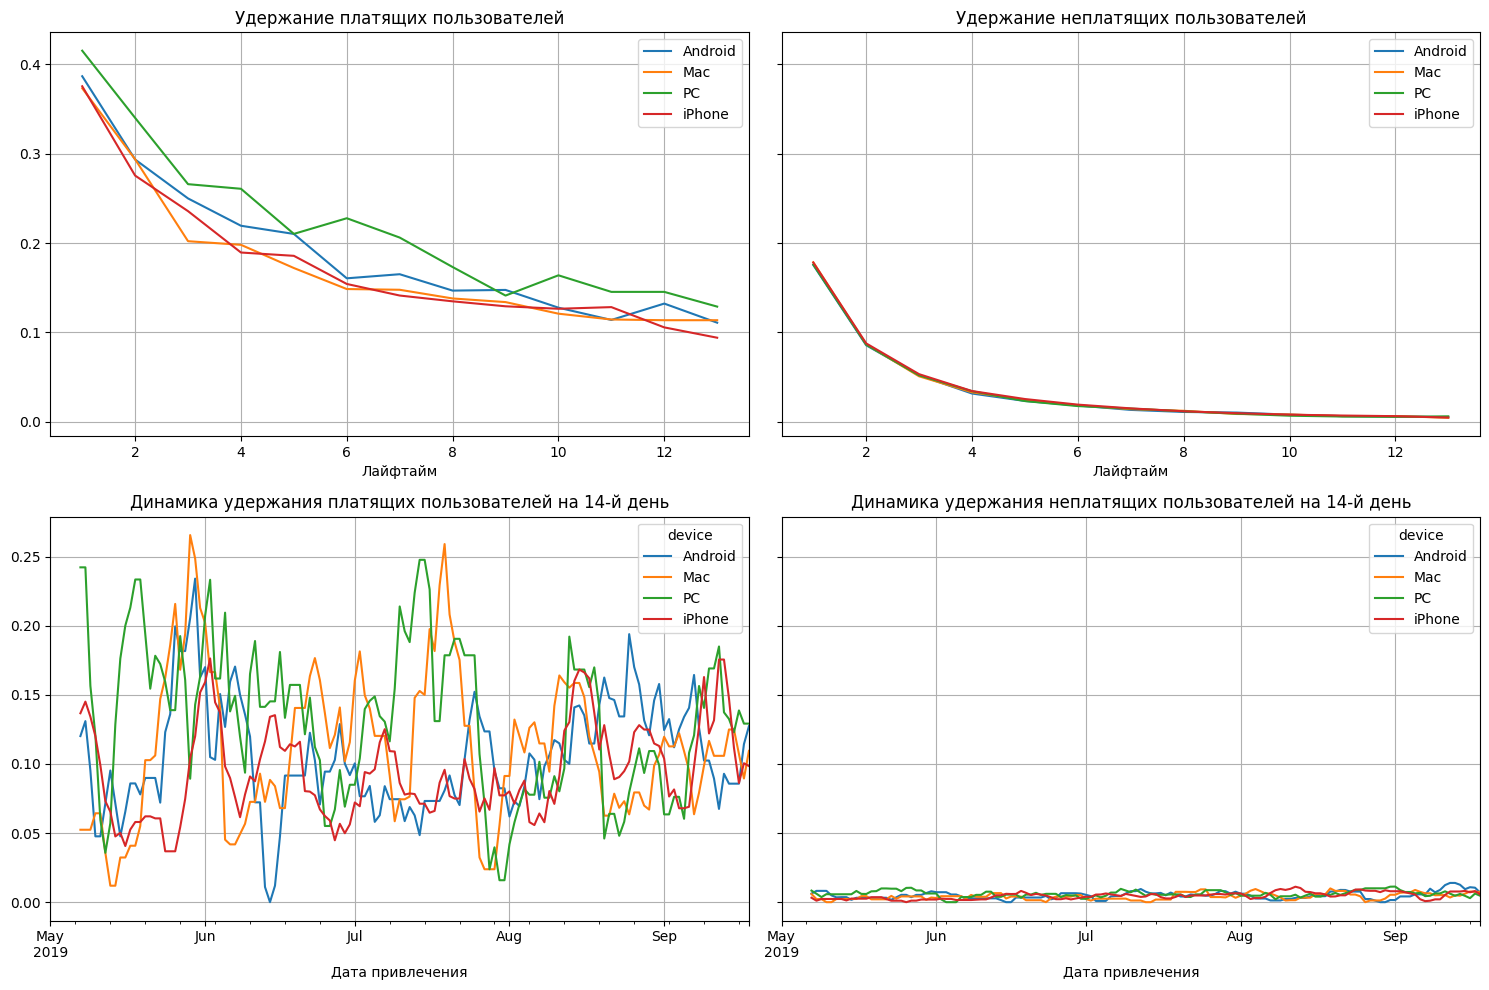

In [77]:
# смотрим удержание с разбивкой по устройствам

dimensions = ['device']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

**Вывод:**
* Аномалии не найдены

#### Разбивка по рекламным каналам

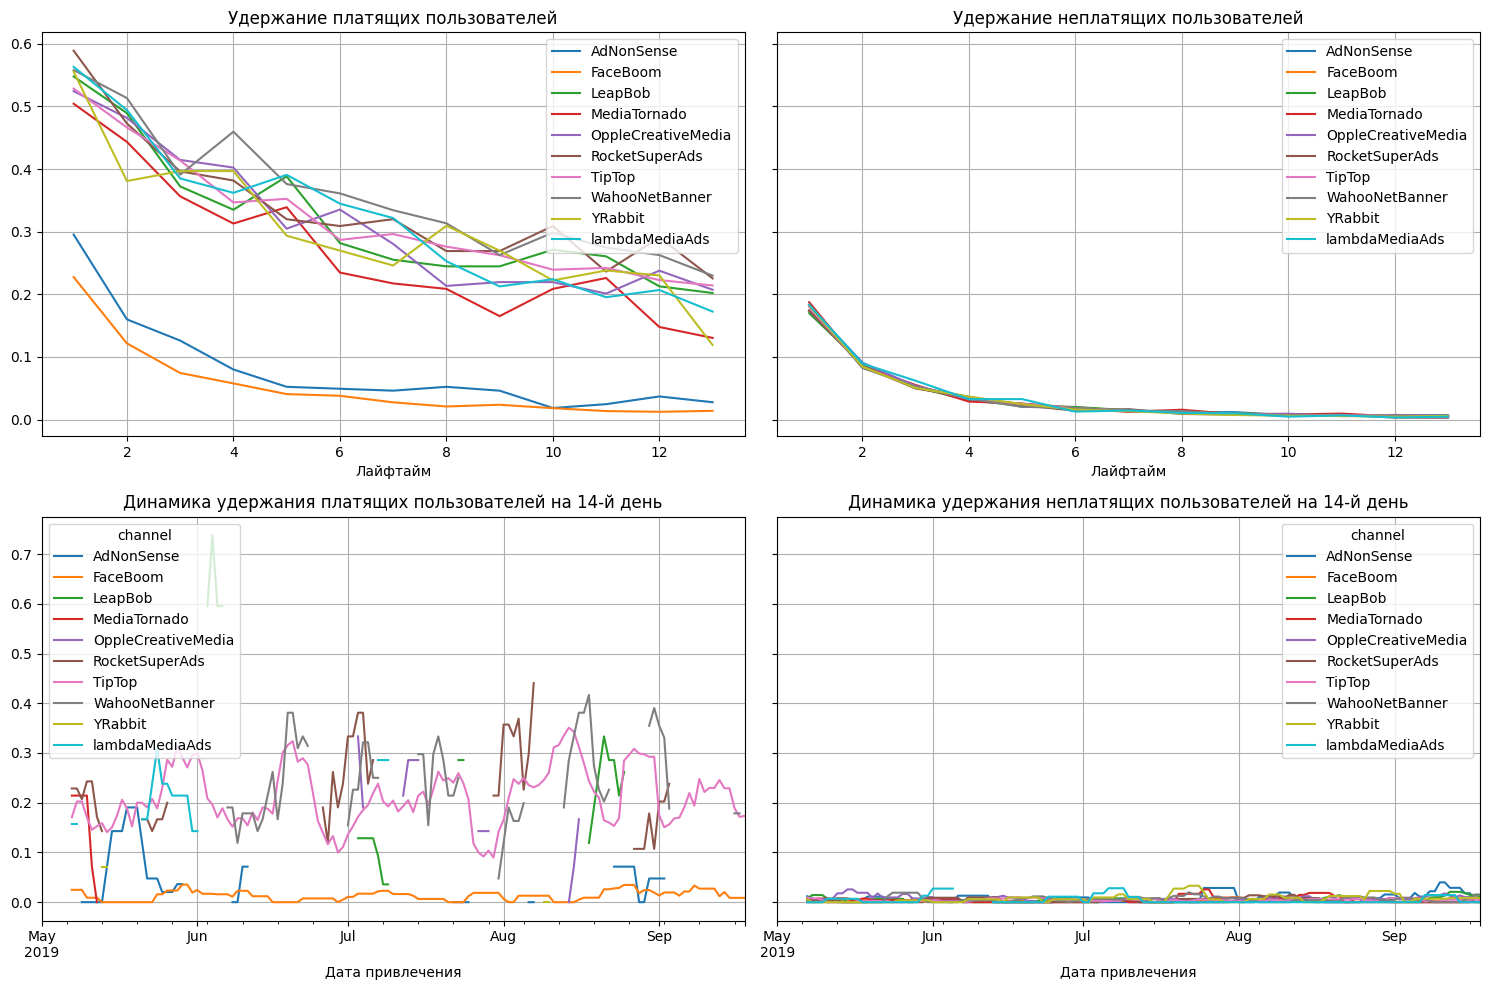

In [78]:
# смотрим удержание с разбивкой по рекламным каналам

dimensions = ['channel']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

**Вывод:**
* Показатель удержания платящих пользователей для AdNonSense и FaceBoom значительно ниже, чем у других каналов
* Найдены проблемные рекламные каналы: AdNonSense и FaceBoom

#### Анализ USA по рекламным каналам
<a id='id_usa_channels'></a>

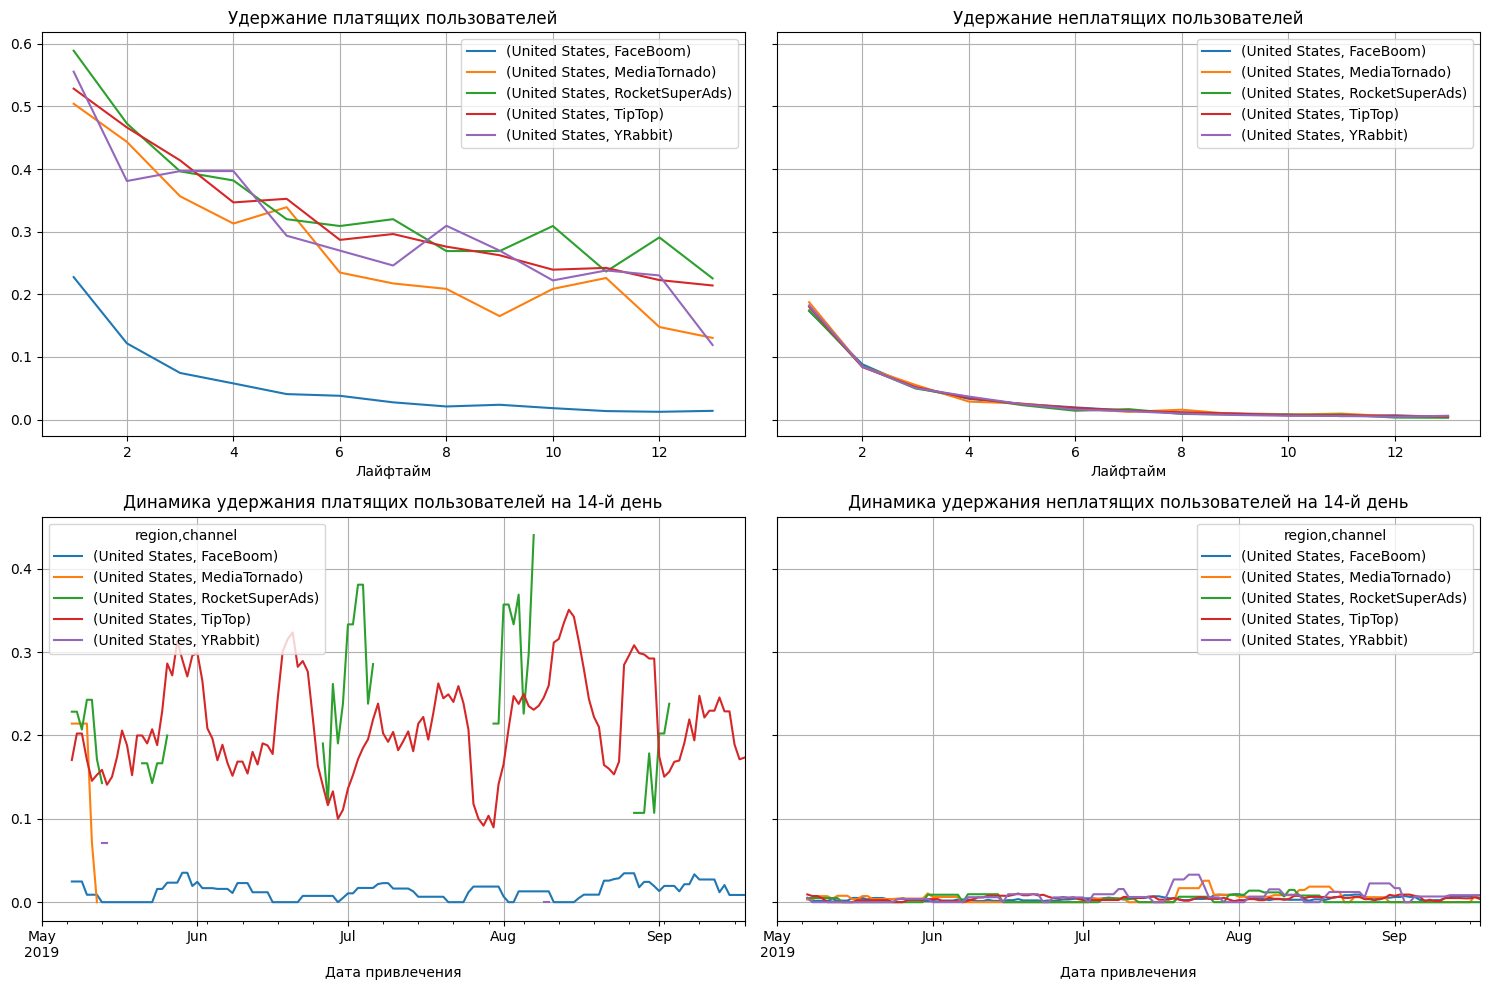

In [79]:
# смотрим удержание с разбивкой по рекламным каналам

dimensions = ['region','channel']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

retention_raw_filtered = retention_raw.query('region=="United States"')
retention_grouped_filtered = retention_grouped.query('region=="United States"')
retention_history_filtered = retention_history.query('region=="United States"')

plot_retention(retention_grouped_filtered, retention_history_filtered, horizon_days)

**Вывод:**
* В ситуации с регионом USA показатель удержания платящих пользователей у FaceBoom значительно хуже, чем у других каналов => проблемный рекламный канал: FaceBoom

## Общий вывод

* Первичный осмотр данных
    - Во всех датасетах отсутствуют полные дубликаты и пропуски => обработка не требуется
    - Во всех датасетах даты имеют тип Object => требуется приведение к типу Date и DateTime
* Исследовательский анализ данных
    - Минимальная дата привлечения пользователей 2019-05-01, максимальная дата привлечения пользователей 2019-10-27
    - Полученные значения минимальной и максимальной даты привлечения пользователей совпадают с описанием данных в проекте
    - Пользователи приходят в приложение из USA, UK, France и Germany
    - Больше всего приходит пользователей из USA. Также в этой стране наибольшая доля платящих пользователей среди всех стран: 4.6% и по региону: 6.9%
    - Наибольшее количество пользователей предпочитают iPhone. На втором месте находится Android
    - Наибольшее количество платящих пользователей предпочитают iPhone: 2.25% и также наибольшая доля платящих для устройства принадлежит iPhone: 6.21%
    - Больше всего платящих пришло с FaceBoom 2.37% и с TipTop 1.25%
    - Так же у пришедших с FaceBoom наибольшая доля платящих пользователей: 12.20%
* Маркетинг
    - Общая сумма расходов на маркетинг: 105497.3
    - Больше всего средств было потрачено на рекламу в TipTop: 51.90%. На втором месте по расходам на рекламу находится FaceBoom: 30.75%
    - На графиках динамики расходов по неделям и месяцам видно, что самый сильный рост затрат на рекламу у TipTop, затем идет FaceBoom
    - Средний CAC на одного пользователя для всего проекта: 0.7
    - Дороже всего средняя стоимость привлечения одного пользователя (CAC) у TipTop: 2.80
* Анализ окупаемости рекламы
    * По графикам LTV и ROI, а также динамике LTV, CAC и ROI
        - LTV постепенно растет, но в динамике на 14й день LTV скорее стоит на месте, чем растет
        - Стоимость привлечения CAC растет. Это может оказывать влияние на окупаемость рекламы
        - Исходя из общего ROI, реклама окупилась. Но в динамике ROI на 14й день, ситуация изменилась в худшую сторону. Реклама перестала окупаться, а тенденция пошла на постепенное снижение в сторону большего ухудшения
        - Стоимость привлечения CAC растет, а окупаемость ROI снижается.
        - Стоимость привлечения CAC у всех стран стабильно на одном уровне, кроме USA. В USA резкий рост стоимости привлечения CAC. 
        - Исходя из ROI, реклама окупилась и растет у всех стран, кроме USA. 
        - В динамике ROI на 14й день, у всех стран ROI стабильно выше уровня окупаемости, кроме USA. Для USA реклама перестала окупаться в начале июня и тенденция идет к дальнейшему снижению в сторону ухудшения
        - Найден проблемный регион. Это USA.
        - Стоимость привлечения CAC по всем устройствам растет 
        - Исходя из ROI, реклама окупилась по PC и Android. По Mac и iPhone еще не перешла уровень окупаемости 
        - В динамике ROI на 14й день, у всех устройств тенденция идет на постепенное снижение ниже уровня окупаемости
        - Негативный фактор по всем устройствам повышение стоимости привлечения CAC. Возможно это послужило причиной ухудшения динамики окупаемости рекламы ROI
        - Стоимость привлечения CAC по всем каналам находится на одном уровне, кроме TipTop. В TipTop наблюдается резкий рост CAC
        - Исходя из ROI и динамики ROI реклама окупилась по всем, кроме TipTop, FaceBoom и AdNonSense
        - Найдены проблемные рекламные каналы. Это TipTop, FaceBoom и AdNonSense 
    * По конверсии пользователей и динамике её изменения
        - Общая конверсия пользователей растет, динамика аналогичная
        - Все в порядке, поэтому не делаем разбивку
    *  По удержанию пользователей
        - Показатель удержания платящих пользователей в USA ниже, чем у других стран
        - Показатель удержания платящих пользователей для AdNonSense и FaceBoom значительно ниже, чем у других каналов
        - Найдены проблемные рекламные каналы: AdNonSense и FaceBoom
        - В ситуации с регионом USA показатель удержания платящих пользователей у FaceBoom значительно хуже, чем у других каналов => проблемный рекламный канал: FaceBoom

## Возможные причины неэффективности привлечения пользователей
- Так как конверсия имеет позитивную динамику, причина неэффективности может быть связана с удержанием пользователей. 

## Рекомендации для отдела маркетинга
- Следует обратить особое внимание на рекламу в регионе USA. Оттуда приходит больше всего пользователей. Также в этой стране наибольшая доля платящих пользователей среди всех стран: 4.6% и по региону: 6.9%. Исследование показало, что в USA резкий рост стоимости привлечения CAC. Возможно это связано с закупкой рекламы в TipTop, тк средняя стоимость привлечения одного пользователя (CAC) у TipTop: 2.80. Это практически в 4 раза превышает CAC на одного пользователя для всего проекта: 0.7. Из-за высокой стоимости реклама в TipTop не окупается. Поэтому рекомендую обратить внимание на другие рекламные каналы, кроме FaceBoom и AdNonSense. Там хотя CAC меньше, но также реклама не окупилась. 
- В ситуации с регионом USA показатель удержания платящих пользователей у FaceBoom значительно хуже, чем у других каналов =>  возможно стоит отказаться от рекламного канала FaceBoom
- Следует обратить внимание на пользователей iPhone, тк наибольшее количество пользователей предпочитают iPhone и наибольшее количество платящих пользователей предпочитают iPhone: 2.25%. А также наибольшая доля платящих для устройства принадлежит iPhone: 6.21%. Но при этом реклама на iPhone не окупилась. Возможно тоже стоит сменить рекламные каналы. 